In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

pd.set_option("display.max_rows", 500)


In [2]:
url = "https://raw.githubusercontent.com/pedroteche-ih/DAFT_MEX_202209/main/data/tb_ames_housing.csv"
tb_housing = pd.read_csv(url)
tb_housing = tb_housing.dropna(axis=1, thresh=tb_housing.shape[0] * 0.5)

X_full = tb_housing.drop("SalePrice", axis=1)
y_full = tb_housing["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, random_state=42)
tb_housing_cat = X_train.select_dtypes(exclude="number")


In [3]:
tb_housing_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 555 to 472
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1095 non-null   object
 1   Street         1095 non-null   object
 2   LotShape       1095 non-null   object
 3   LandContour    1095 non-null   object
 4   Utilities      1095 non-null   object
 5   LotConfig      1095 non-null   object
 6   LandSlope      1095 non-null   object
 7   Neighborhood   1095 non-null   object
 8   Condition1     1095 non-null   object
 9   Condition2     1095 non-null   object
 10  BldgType       1095 non-null   object
 11  HouseStyle     1095 non-null   object
 12  RoofStyle      1095 non-null   object
 13  RoofMatl       1095 non-null   object
 14  Exterior1st    1095 non-null   object
 15  Exterior2nd    1095 non-null   object
 16  MasVnrType     1090 non-null   object
 17  ExterQual      1095 non-null   object
 18  ExterCond      1095 non-nul

# Treatment of Categorical Variables

In [4]:
tb_housing_cat['SaleType'].value_counts()

WD       945
New       94
COD       36
ConLD      7
ConLI      4
ConLw      4
CWD        3
Con        1
Oth        1
Name: SaleType, dtype: int64

## Dealing with rare & missing levels

In [5]:
bnl_list = []
mcl_list = []
lcl_list = []
na_list = []
column_list = []

for column in tb_housing_cat.columns:
    num_levels = len(tb_housing_cat[column].unique())
    most_common_level = tb_housing_cat[column].value_counts().max()
    least_common_level = tb_housing_cat[column].value_counts().min()
    num_non_na = (~tb_housing_cat[column].isna()).sum()

    column_list.append(column)
    nl_list.append(num_levels)
    mcl_list.append(most_common_level)
    lcl_list.append(least_common_level)
    na_list.append(num_non_na)

tb_cat_info = pd.DataFrame(
    {
        "column": column_list,
        "num_levels": nl_list,
        "most_common_level": mcl_list,
        "least_common_level": lcl_list,
        "num_nonna": na_list,
    }
)
tb_cat_info


,column,num_levels,most_common_level,least_common_level,num_nonna
0,MSZoning,5,871,6,1095
1,Street,2,1090,5,1095
2,LotShape,4,694,6,1095
3,LandContour,4,994,28,1095
4,Utilities,2,1094,1,1095
5,LotConfig,5,788,3,1095
6,LandSlope,3,1041,11,1095
7,Neighborhood,24,169,7,1095
8,Condition1,9,943,2,1095
9,Condition2,8,1083,1,1095


In [6]:
big_level_thresh = (tb_cat_info["most_common_level"] / tb_cat_info["num_nonna"]) < 0.9
big_level_thresh

0      True
1     False
2      True
3     False
4     False
5      True
6     False
7      True
8      True
9     False
10     True
11     True
12     True
13    False
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21    False
22     True
23     True
24     True
25    False
26     True
27    False
28    False
29     True
30    False
31     True
32     True
33     True
34    False
35    False
36    False
37     True
38     True
dtype: bool

In [7]:
big_level_thresh = (tb_cat_info["most_common_level"] / tb_cat_info["num_nonna"]) < 0.9
tb_cat_info = tb_cat_info[big_level_thresh].copy()
tb_cat_info


,column,num_levels,most_common_level,least_common_level,num_nonna
0,MSZoning,5,871,6,1095
2,LotShape,4,694,6,1095
5,LotConfig,5,788,3,1095
7,Neighborhood,24,169,7,1095
8,Condition1,9,943,2,1095
10,BldgType,5,917,26,1095
11,HouseStyle,8,534,7,1095
12,RoofStyle,6,843,2,1095
14,Exterior1st,14,391,1,1095
15,Exterior2nd,15,382,1,1095


In [11]:
tb_housing_cat[column].value_counts().reset_index()

,index,SaleCondition
0,Normal,903
1,Partial,95
2,Abnorml,70
3,Family,17
4,Alloca,7
5,AdjLand,3


In [8]:
tb_cat_levels = pd.DataFrame()

for column in tb_housing_cat.columns:
    num_obs_level = tb_housing_cat[column].value_counts().reset_index()
    num_obs_level.columns = ["level_name", "num_obs"]
    num_obs_level["column"] = column
    tb_cat_levels = pd.concat([tb_cat_levels, num_obs_level], axis=0)

tb_cat_levels.head(10)


,level_name,num_obs,column
0,RL,871,MSZoning
1,RM,161,MSZoning
2,FV,47,MSZoning
3,RH,10,MSZoning
4,C (all),6,MSZoning
0,Pave,1090,Street
1,Grvl,5,Street
0,Reg,694,LotShape
1,IR1,364,LotShape
2,IR2,31,LotShape


In [12]:
tb_cat_level_info = tb_cat_info.merge(tb_cat_levels, on="column")
tb_cat_level_info.head()


,column,num_levels,most_common_level,least_common_level,num_nonna,level_name,num_obs
0,MSZoning,5,871,6,1095,RL,871
1,MSZoning,5,871,6,1095,RM,161
2,MSZoning,5,871,6,1095,FV,47
3,MSZoning,5,871,6,1095,RH,10
4,MSZoning,5,871,6,1095,C (all),6


In [13]:
tb_cat_level_info.loc[tb_cat_level_info["num_obs"] > 50, "grp_level"] = tb_cat_level_info["level_name"]

tb_cat_level_info.loc[tb_cat_level_info["num_obs"] <= 50, "grp_level"] = "Others"
tb_cat_level_info.head(20)


,column,num_levels,most_common_level,least_common_level,num_nonna,level_name,num_obs,grp_level
0,MSZoning,5,871,6,1095,RL,871,RL
1,MSZoning,5,871,6,1095,RM,161,RM
2,MSZoning,5,871,6,1095,FV,47,Others
3,MSZoning,5,871,6,1095,RH,10,Others
4,MSZoning,5,871,6,1095,C (all),6,Others
5,LotShape,4,694,6,1095,Reg,694,Reg
6,LotShape,4,694,6,1095,IR1,364,IR1
7,LotShape,4,694,6,1095,IR2,31,Others
8,LotShape,4,694,6,1095,IR3,6,Others
9,LotConfig,5,788,3,1095,Inside,788,Inside


In [15]:
tb_cat_level_info.shape


(172, 8)

In [16]:
tb_cat_level_info.groupby(["column", "grp_level"])["level_name"].count().reset_index().shape


(101, 3)

In [24]:
tb_column = tb_cat_level_info[tb_cat_level_info["column"] == 'LotConfig']
tb_column.loc[tb_column["level_name"] == 'FR2', "grp_level"].item()

'Others'

In [27]:
tb_column.iloc[1,5]

'Corner'

In [26]:
tb_column

,column,num_levels,most_common_level,least_common_level,num_nonna,level_name,num_obs,grp_level
9,LotConfig,5,788,3,1095,Inside,788,Inside
10,LotConfig,5,788,3,1095,Corner,194,Corner
11,LotConfig,5,788,3,1095,CulDSac,71,CulDSac
12,LotConfig,5,788,3,1095,FR2,39,Others
13,LotConfig,5,788,3,1095,FR3,3,Others


In [20]:
for column in tb_cat_level_info["column"].unique():
    tb_column = tb_cat_level_info[tb_cat_level_info["column"] == column]
    grp_dict = dict()

    for level in tb_column["level_name"].unique():
        grp_dict[level] = tb_column.loc[tb_column["level_name"] == level, "grp_level"].item()

    new_column = "grp_" + column
    X_train[new_column] = X_train[column].map(grp_dict).fillna("Others")


In [21]:
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,grp_BsmtExposure,grp_BsmtFinType1,grp_BsmtFinType2,grp_HeatingQC,grp_KitchenQual,grp_FireplaceQu,grp_GarageType,grp_GarageFinish,grp_SaleType,grp_SaleCondition
555,556,45,RM,58.0,6380,Pave,Reg,Lvl,AllPub,Inside,...,No,Unf,Unf,TA,TA,Gd,Detchd,Unf,WD,Normal
962,963,160,RL,24.0,2308,Pave,Reg,Lvl,AllPub,Corner,...,No,ALQ,Unf,TA,Gd,TA,Detchd,Unf,WD,Normal
303,304,20,RL,70.0,9800,Pave,Reg,Lvl,AllPub,Corner,...,No,ALQ,Unf,TA,TA,Others,Attchd,Unf,WD,Abnorml
613,614,20,RL,70.0,8402,Pave,Reg,Lvl,AllPub,Inside,...,No,ALQ,Unf,Ex,TA,Others,Others,Others,New,Partial
89,90,20,RL,60.0,8070,Pave,Reg,Lvl,AllPub,Inside,...,No,GLQ,Unf,Ex,TA,Others,Others,Others,WD,Normal


### Writing a wrapper

In [29]:
def create_group_dict(categorical_data, mcl_level=0.9, min_obs=50):
    # Creating measurements of categorical data quality
    nl_list = []
    mcl_list = []
    lcl_list = []
    na_list = []
    column_list = []
    for column in categorical_data.columns:
        num_levels = len(categorical_data[column].unique())
        most_common_level = categorical_data[column].value_counts().max()
        least_common_level = categorical_data[column].value_counts().min()
        num_non_na = (~categorical_data[column].isna()).sum()
        column_list.append(column)
        nl_list.append(num_levels)
        mcl_list.append(most_common_level)
        lcl_list.append(least_common_level)
        na_list.append(num_non_na)
    tb_cat_info = pd.DataFrame(
        {
            "column": column_list,
            "num_levels": nl_list,
            "most_common_level": mcl_list,
            "least_common_level": lcl_list,
            "num_nonna": na_list,
        }
    )
    # Filtering columns with low variance (most values are the same)
    big_level_thresh = (
        tb_cat_info["most_common_level"] / tb_cat_info["num_nonna"]
    ) < mcl_level
    tb_cat_info = tb_cat_info[big_level_thresh].copy()

    # Creating categorical level information DataFrame
    tb_cat_levels = pd.DataFrame()
    for column in categorical_data.columns:
        num_obs_level = categorical_data[column].value_counts().reset_index()
        num_obs_level.columns = ["level_name", "num_obs"]
        num_obs_level["column"] = column
        tb_cat_levels = pd.concat([tb_cat_levels, num_obs_level], axis=0)
    tb_cat_level_info = tb_cat_info.merge(tb_cat_levels, on="column")

    # Creating grouping dictionaries for each categorical observation
    tb_cat_level_info.loc[
        tb_cat_level_info["num_obs"] > min_obs, "grp_level"
    ] = tb_cat_level_info["level_name"]
    tb_cat_level_info.loc[
        tb_cat_level_info["num_obs"] <= min_obs, "grp_level"
    ] = "Others"
    column_grp_dict = dict()
    for column in tb_cat_level_info["column"].unique():
        tb_column = tb_cat_level_info[tb_cat_level_info["column"] == column]
        grp_dict = dict()

        for level in tb_column["level_name"].unique():
            grp_dict[level] = tb_column.loc[
                tb_column["level_name"] == level, "grp_level"
            ].item()

        column_grp_dict[column] = grp_dict

    return column_grp_dict


In [30]:
col_grp_dict = create_group_dict(X_train.select_dtypes(exclude="number"))


The `create_group_dict` is the `fit` part of our transformation. Now we must create a wrapper for the application of the dictionary (the `transform` part):

In [32]:
def group_cat_levels(categorical_data, col_grp_dict):
    # Drop columns that are not mapped in our col_grp_dict
    categorical_data = categorical_data[col_grp_dict.keys()].copy()
    
    # Apply our dictionaries to the remaining columns
    for column in col_grp_dict.keys():
        grp_dict = col_grp_dict[column]
        categorical_data[column] = (
            categorical_data[column].map(grp_dict).fillna("Others")
        )

    return categorical_data


Let's test our wrappers on the housing dataset:

In [34]:
tb_housing = pd.read_csv(url)
tb_housing = tb_housing.dropna(axis=1, thresh=tb_housing.shape[0] * 0.5)

X_full = tb_housing.drop("SalePrice", axis=1)
y_full = tb_housing["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full)
tb_housing_cat = X_train.select_dtypes(exclude="number")

col_grp_dict = create_group_dict(X_train.select_dtypes(exclude="number"),
                                 mcl_level = 0.5, 
                                 min_obs = X_train.shape[0] * 0.05)
X_train_cat_grp = group_cat_levels(
    X_train.select_dtypes(exclude="number"), col_grp_dict
)
X_test_cat_grp = group_cat_levels(X_test.select_dtypes(exclude="number"), col_grp_dict)
X_train_cat_grp


,Neighborhood,Exterior1st,Exterior2nd,Foundation,BsmtQual,BsmtFinType1,FireplaceQu,GarageFinish
1355,Others,MetalSd,MetalSd,CBlock,TA,Unf,TA,RFn
950,NAmes,VinylSd,VinylSd,CBlock,TA,ALQ,Others,RFn
425,OldTown,HdBoard,HdBoard,CBlock,TA,Unf,Gd,Unf
153,Others,Others,Plywood,CBlock,Gd,BLQ,Gd,RFn
1162,Sawyer,VinylSd,VinylSd,CBlock,Gd,BLQ,Others,Fin
...,...,...,...,...,...,...,...,...
948,CollgCr,VinylSd,VinylSd,PConc,Gd,Unf,TA,RFn
544,Gilbert,VinylSd,VinylSd,PConc,Gd,GLQ,Gd,RFn
763,Others,VinylSd,VinylSd,PConc,Gd,GLQ,Gd,RFn
1073,Edwards,HdBoard,Plywood,CBlock,TA,BLQ,Others,Fin


Now we can train our One-Hot Encoder on our transformed categorical variables:

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [40]:
tb_housing = pd.read_csv(url)
tb_housing = tb_housing.dropna(axis=1, thresh=tb_housing.shape[0] * 0.5)

X_full = tb_housing.drop("SalePrice", axis=1)
y_full = tb_housing["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full)
tb_housing_cat = X_train.select_dtypes(exclude="number")

col_grp_dict = create_group_dict(X_train.select_dtypes(exclude="number"),
                                 mcl_level = 0.8, 
                                 min_obs = X_train.shape[0] * 0.05)
X_train_cat_grp = group_cat_levels(
    X_train.select_dtypes(exclude="number"), col_grp_dict
)
X_test_cat_grp = group_cat_levels(X_test.select_dtypes(exclude="number"), col_grp_dict)
X_train_cat_grp


ohe_fit = OneHotEncoder(sparse=False, handle_unknown="ignore")
ohe_fit.fit(X_train_cat_grp)


X_train_dummy = pd.DataFrame(
    ohe_fit.transform(X_train_cat_grp), columns=ohe_fit.get_feature_names_out()
)
X_test_dummy = pd.DataFrame(
    ohe_fit.transform(X_test_cat_grp), columns=ohe_fit.get_feature_names_out()
)
print(X_train_dummy.shape)

(1095, 84)


In [41]:
len(col_grp_dict.keys())

19

# Complex Encoding Strategies

## Choosing categorical levels

In [42]:
from sklearn.feature_selection import mutual_info_regression
# You can also use mutual_info_classif for classification problems


In [43]:
mir_fit = mutual_info_regression(X_train_dummy, y_train, discrete_features=True)


In [52]:
pd.DataFrame(mir_fit, index = X_train_dummy.columns).reset_index().sort_values(by = 0, ascending =False).head()

,index,0
44,ExterQual_TA,0.249620
72,KitchenQual_TA,0.216069
42,ExterQual_Gd,0.206896
48,Foundation_PConc,0.199166
70,KitchenQual_Gd,0.187999


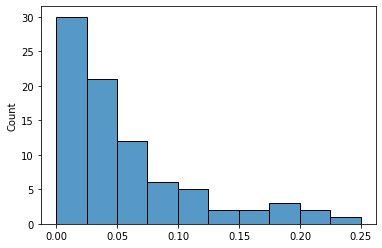

In [53]:
sns.histplot(mir_fit)


In [55]:
mir_fit > np.quantile(mir_fit, 0.75)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False,  True, False, False,  True, False,  True,
       False,  True, False,  True,  True,  True, False,  True, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True, False, False,  True,  True,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False, False,  True])

In [58]:
imp_dummy_var = X_train_dummy.columns[mir_fit > np.quantile(mir_fit, 0.75)]


## MCA

In [59]:
!pip install prince

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
import prince


In [62]:
X_train_cat_grp.head() # chi-2

,MSZoning,LotShape,LotConfig,Neighborhood,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,FireplaceQu,GarageType,GarageFinish
77,RM,Reg,Inside,Others,1.5Fin,Gable,Wd Sdng,Wd Sdng,None,TA,CBlock,TA,No,BLQ,TA,TA,Others,Detchd,Unf
563,RL,Reg,Inside,Edwards,1.5Fin,Gable,Wd Sdng,Wd Sdng,None,TA,BrkTil,Gd,Mn,Unf,Ex,TA,Gd,Detchd,Fin
966,RL,IR1,Inside,Others,1.5Fin,Gable,MetalSd,MetalSd,None,Gd,BrkTil,TA,No,Rec,Ex,TA,TA,Detchd,Unf
1394,RL,Reg,Inside,Others,1Story,Hip,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,Av,GLQ,Ex,Gd,Gd,Attchd,Fin
823,RL,Reg,Inside,Others,1.5Fin,Gable,VinylSd,VinylSd,None,TA,BrkTil,TA,No,Unf,TA,TA,Gd,Detchd,Unf


In [81]:
pd.get_dummies(X_train_cat_grp, drop_first = True).shape

(1095, 65)

In [76]:
mca_fit = prince.MCA(n_components = 84)
mca_fit.fit(X_train_cat_grp)


MCA(n_components=84)

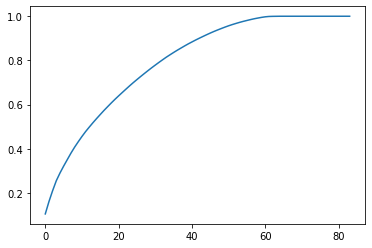

In [77]:
plt.plot(np.cumsum(mca_fit.explained_inertia_))


In [78]:
len(X_train_cat_grp.columns)

19

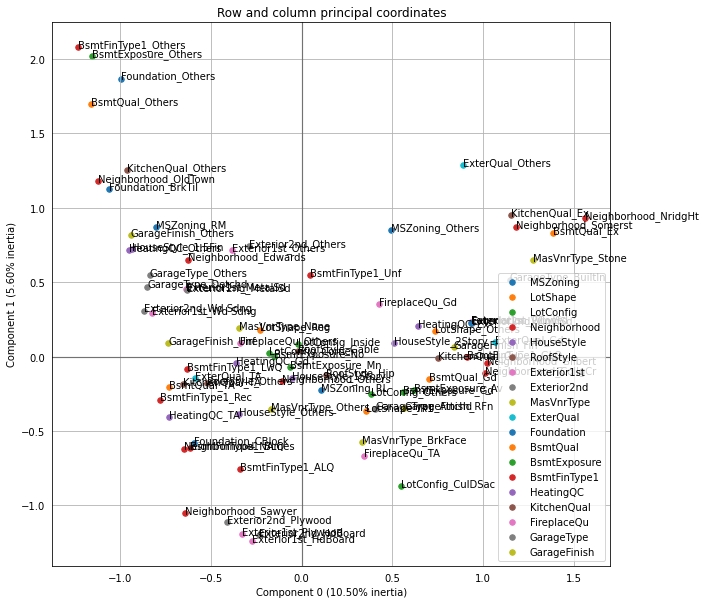

In [79]:
mca_fit.plot_coordinates(X_train_cat_grp, show_row_points=False, figsize=(10, 10), show_column_labels = True)


In [80]:
mca_fit.transform(X_train_cat_grp)

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
77,-0.890487,0.124353,-0.464543,0.017448,-0.238582,-0.288832,0.216469,0.182248,0.033466,0.037899,...,0.065941,0.088754,-0.06434,-0.034053,-0.031593,0.082965,-0.039659,0.03453,-0.061217,-0.077345
563,-0.380443,0.535568,-0.441401,-0.038195,-0.471741,-0.363101,0.282700,0.229976,-0.261512,0.329881,...,0.065941,0.088754,-0.06434,-0.034053,-0.031593,0.082965,-0.039659,0.03453,-0.061217,-0.077345
966,-0.452507,0.219854,-0.527439,-0.108584,0.259236,-0.150471,-0.484473,0.145171,-0.411030,0.084040,...,0.065941,0.088754,-0.06434,-0.034053,-0.031593,0.082965,-0.039659,0.03453,-0.061217,-0.077345
1394,0.817316,-0.036379,0.061408,0.020809,0.024831,-0.054400,0.132143,0.005856,0.067010,-0.181787,...,0.065941,0.088754,-0.06434,-0.034053,-0.031593,0.082965,-0.039659,0.03453,-0.061217,-0.077345
823,-0.414621,0.352218,-0.430785,-0.111625,-0.187890,-0.260455,-0.066182,0.068204,-0.021716,-0.193880,...,0.065941,0.088754,-0.06434,-0.034053,-0.031593,0.082965,-0.039659,0.03453,-0.061217,-0.077345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,-0.164128,-0.786687,0.200416,0.189515,0.081773,-0.024662,-0.109296,-0.548033,0.018621,0.010867,...,0.065941,0.088754,-0.06434,-0.034053,-0.031593,0.082965,-0.039659,0.03453,-0.061217,-0.077345
660,-0.023536,-0.734371,0.262350,-0.187035,-0.363844,0.198949,-0.542581,0.580073,-0.116380,0.025925,...,0.065941,0.088754,-0.06434,-0.034053,-0.031593,0.082965,-0.039659,0.03453,-0.061217,-0.077345
494,-0.743859,0.737217,-0.270906,-0.285861,0.326049,-0.171585,-0.411884,-0.131786,-0.380454,-0.313151,...,0.065941,0.088754,-0.06434,-0.034053,-0.031593,0.082965,-0.039659,0.03453,-0.061217,-0.077345
500,-0.600510,-0.409280,-0.118233,-0.005495,0.149713,-0.141432,-0.198974,-0.582514,0.148165,-0.031229,...,0.065941,0.088754,-0.06434,-0.034053,-0.031593,0.082965,-0.039659,0.03453,-0.061217,-0.077345


In [83]:
tb_mca = mca_fit.transform(X_train_cat_grp)
tb_mca.columns = ['MC_' + str(i) for i in range(84)]
tb_mca['log_SalePrice'] = np.log(y_train)

In [84]:
tb_mca.head()

,MC_0,MC_1,MC_2,MC_3,MC_4,MC_5,MC_6,MC_7,MC_8,MC_9,...,MC_75,MC_76,MC_77,MC_78,MC_79,MC_80,MC_81,MC_82,MC_83,log_SalePrice
77,-0.890487,0.124353,-0.464543,0.017448,-0.238582,-0.288832,0.216469,0.182248,0.033466,0.037899,...,0.088754,-0.06434,-0.034053,-0.031593,0.082965,-0.039659,0.03453,-0.061217,-0.077345,11.751942
563,-0.380443,0.535568,-0.441401,-0.038195,-0.471741,-0.363101,0.282700,0.229976,-0.261512,0.329881,...,0.088754,-0.06434,-0.034053,-0.031593,0.082965,-0.039659,0.03453,-0.061217,-0.077345,12.128111
966,-0.452507,0.219854,-0.527439,-0.108584,0.259236,-0.150471,-0.484473,0.145171,-0.411030,0.084040,...,0.088754,-0.06434,-0.034053,-0.031593,0.082965,-0.039659,0.03453,-0.061217,-0.077345,11.982929
1394,0.817316,-0.036379,0.061408,0.020809,0.024831,-0.054400,0.132143,0.005856,0.067010,-0.181787,...,0.088754,-0.06434,-0.034053,-0.031593,0.082965,-0.039659,0.03453,-0.061217,-0.077345,12.415434
823,-0.414621,0.352218,-0.430785,-0.111625,-0.187890,-0.260455,-0.066182,0.068204,-0.021716,-0.193880,...,0.088754,-0.06434,-0.034053,-0.031593,0.082965,-0.039659,0.03453,-0.061217,-0.077345,11.845820


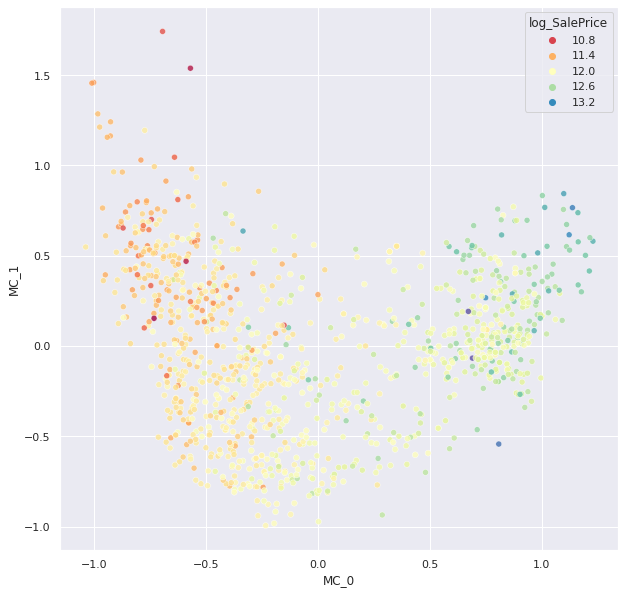

In [91]:

sns.set_theme(context = 'notebook', style = 'darkgrid')
fig, ax = plt.subplots(1,1, figsize = (10, 10))
sns.scatterplot(data = tb_mca, x = 'MC_0', y = 'MC_1', hue = 'log_SalePrice', palette="Spectral", alpha = 0.8)

In [86]:
X_train_mca = mca_fit.transform(X_train_cat_grp)
X_test_mca = mca_fit.transform(X_test_cat_grp)


# Testing the full model

In [92]:
from sklearn.decomposition import PCA

In [93]:
X_train_num = X_train.select_dtypes(include = 'number').fillna(0)
X_test_num = X_test.select_dtypes(include = 'number').fillna(0)

In [94]:
pca_fit = PCA()
pca_fit.fit(X_train_num)

PCA()

In [96]:
X_train_pca = pd.DataFrame(
    pca_fit.transform(X_train_num),
    columns = ['PC_' + str(i) for i in range(pca_fit.n_components_)],
    index = y_train.index
)
X_test_pca = pd.DataFrame(
    pca_fit.transform(X_test_num),
    columns = ['PC_' + str(i) for i in range(pca_fit.n_components_)],
    index = y_test.index
)

In [97]:
X_train_full = pd.concat([X_train_mca, X_train_pca], axis = 1)
X_test_full = pd.concat([X_test_mca, X_test_pca], axis = 1)

In [98]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [108]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [109]:
#cat_fit = CatBoostRegressor(iterations=20000, depth=8, od_type="Iter", od_wait=1500, verbose = False)
#cat_fit.fit(X_train_full, y_train, eval_set=(X_test_full, y_test))
cat_fit = LinearRegression()
cat_fit.fit(X_train_full, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


LinearRegression()

In [111]:
y_pred = cat_fit.predict(X_test_full)
print(f"RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R2 {r2_score(y_test, y_pred)}")

RMSE 30637.62919064827
R2 0.8461150878808864


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
# See you in 5m!